<a href="https://colab.research.google.com/github/sonjaove/progg-and-DS-from-IITM/blob/ML/Copy_of_Week_4_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week-4: Part-2


In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Set size of figure
plt.rcParams['figure.figsize'] = [8, 8]
# Set size of font
plt.rcParams['font.size'] = 10

## GMM

Now that we know how to sample from simple distributions like the Bernoulli and Gaussian, we shall move to sampling from a GMM. There are two steps here:

- Pick a mixture $k$ from $K$ mixtures based on the categorical distribution governing it
- Sample a point from the $k^{th}$ Gaussian

## Problem-1

Consider a GMM with $K = 3$. The mixture probabilities are given below. It is easier to work with zero-indexing, hence we will index our mixtures starting from $0$:

$$
\pi_0 = 0.3\\
\pi_1 = 0.5\\
\pi_2 = 0.2
$$

Perform step-1 of the sampling process by choosing one of the three mixtures based on the above distribution. Call this value $k$. Use the cell given below for all your computation. Do not change the seed value. Enter $k$ as your answer.

In [2]:
### RNG ###
rng = np.random.default_rng(seed = 1001)
### Solution ###
pi = [0.3, 0.5, 0.2]

# Step 1: Sampling mixture component
k = rng.choice(3, p=pi)
k

1

## Problem-2

Now we move to step-2 of the sampling process. Sample a point from mixture $k$ (obtained from the previous question). The means and variances of the mixtures are as follows:

$$
\mu_1 = -4, \sigma_1^2 = 2\\
\mu_2 = 0, \sigma_2^2 = 1\\
\mu_3 = 5, \sigma_3^2 = 3
$$


Use the cell given below for all your computation. Enter the sampled point correct to three decimal places.

In [5]:
# Resetting the random generator with the same seed to ensure consistency
rng = np.random.default_rng(seed=1001)

# Chosen mixture is k = 1, so using mu_1 = 0, sigma_1^2 = 1
chosen_mean = 0
chosen_std_dev = np.sqrt(1)

# Sampling a point again after resetting the seed
sampled_point_correct = rng.normal(chosen_mean, chosen_std_dev)
round(sampled_point_correct, 3)

0.932

## Problem-3

Now that we have sampled one point, we are ready to do more. Sample $100,000$ points from the GMM. Generate each point step by step. Store the samples in a NumPy array `X` of shape $(100,000, )$. `X[i]` should hold the value of the $i^{th}$ point generated from the GMM.  Use the cell below for all your computation. Enter the mean of `X` as your answer correct to three decimal places.

In [6]:
### RNG ###
rng = np.random.default_rng(seed = 1001)
### Solution ###
# Mixture probabilities and parameters
pi = [0.3, 0.5, 0.2]
means = [-4, 0, 5]
variances = [2, 1, 3]

# Number of samples
n_samples = 100000

# Step-by-step sampling process for 100,000 points
X = np.zeros(n_samples)
for i in range(n_samples):
    # Step 1: Sample a mixture component
    k = rng.choice(3, p=pi)

    # Step 2: Sample from the chosen Gaussian
    X[i] = rng.normal(means[k], np.sqrt(variances[k]))

# Calculate the mean of X
mean_X = np.mean(X)
round(mean_X, 3)


-0.193

## Problem-4

Plot a histogram of the dataset. Play around with the `bins` parameter of the `plt.hist` method. We will be using this dataset `X` all through the next section of the colab.

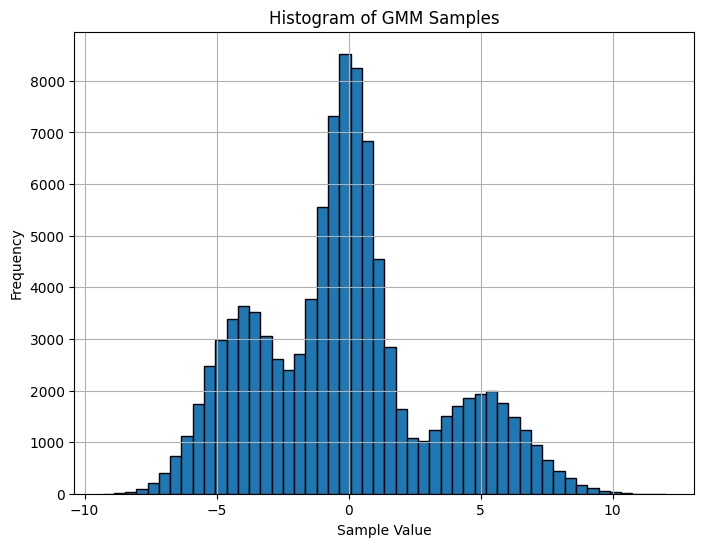

In [7]:
### Solution ###
import matplotlib.pyplot as plt

# Plotting the histogram of the dataset X
plt.figure(figsize=(8, 6))
plt.hist(X, bins=50, edgecolor='black')
plt.title('Histogram of GMM Samples')
plt.xlabel('Sample Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


## EM algorithm

It is time to start coding up the EM algorithm from scratch. We will break this down into five stages:

- Initialization
- E-step
- M-step
- Stopping criterion
- Algorithm

For each of the first four stages, we will write functions that are related to that stage. All these functions will be eventually used in the code for the EM algorithm. This is a modular approach to writing the code. We have identified four blocks or stages. We can independently work on these four blocks and finally combine them. If something goes wrong, we can quickly localize the problem to one of these four blocks.


## Problem-5

Write a function `init` that initializes the parameters of the GMM and returns `theta_0`, a NumPy array of shape $(3K, )$. The first $K$ elements of `theta_0` ($\boldsymbol{\theta}^{(0)}$) represents the means of the three mixtures, the next $K$ represent the variances and the last $K$ represent the mixture probabilities.

The exact values to be used are as follows:

- $\mu_0 = 1, \mu_1 = 2, \mu_2 = 3$
- $\sigma_0^2 = \sigma_1^2 = \sigma_2^2 = 1$
- $\pi_0 = \pi_1 = \pi_2 = 1/3$

Enter $||\boldsymbol{\theta}^{(0)}||$ as your answer correct to two decimal places. Keep this variable `theta_0` as it will be used in subsequent problems.

In [8]:
### Solution ###
# Function to initialize the parameters of the GMM
def init():
    # Means
    mus = np.array([1, 2, 3])

    # Variances
    sigmas_squared = np.array([1, 1, 1])

    # Mixture probabilities
    pis = np.array([1/3, 1/3, 1/3])

    # Combine all into a single array
    theta_0 = np.concatenate([mus, sigmas_squared, pis])
    return theta_0

# Initialize and calculate the norm of theta_0
theta_0 = init()
theta_0_norm = np.linalg.norm(theta_0)
round(theta_0_norm, 2)


4.16

## Problem-6

Write a function `estep` that accepts `theta` and `X` as arguments. It should perform the E-step and return an array `lamb` of shape `(n, K)`. The element `lamb[i][k]` is equal to $\lambda_k^{i}$. For the purposes of evaluation, run the function on `theta_0` and `X`. Call the returned value `lamb_1`.  Compute the sum of the zeroth column of the matrix `lamb_1` and enter that as your answer correct to two decimal places. Keep this variable `lamb_1` as it will be used in subsequent problems.


**Aside**: We prefer the variable name `lamb` over `lambda` for a reason. Can you guess why?

In [9]:
### Solution ###
# Function to compute the E-step
def estep(theta, X):
    n = X.shape[0]
    K = 3

    # Extract parameters from theta
    mus = theta[:K]
    sigmas_squared = theta[K:2*K]
    pis = theta[2*K:]

    # Initialize lamb matrix
    lamb = np.zeros((n, K))

    # Compute lambda_k^i for each i and k
    for k in range(K):
        # Gaussian probability density function for each component
        coeff = 1 / np.sqrt(2 * np.pi * sigmas_squared[k])
        exp_term = np.exp(-0.5 * (X - mus[k])**2 / sigmas_squared[k])

        # Calculate lambda_k^i
        lamb[:, k] = pis[k] * coeff * exp_term

    # Normalize lamb values across k for each i (E-step)
    lamb_sum = np.sum(lamb, axis=1, keepdims=True)
    lamb /= lamb_sum

    return lamb

# Run the estep function on theta_0 and X
lamb_1 = estep(theta_0, X)

# Compute the sum of the zeroth column of lamb_1
sum_zeroth_column = np.sum(lamb_1[:, 0])
round(sum_zeroth_column, 2)


68226.2

## Problem-7

Write a function `mstep` that accepts `lamb` and `X` as arguments. It should perform the M-step and return a NumPy array `theta`, the updated parameters, namely. We follow the same convention for storing the parameters as was done during the init step. For the purposes of evaluation, compute the value of the function for `lamb_1` and `X`. Call the returned value `theta_1` ($\boldsymbol{\theta}^{(1)}$). Enter $||\boldsymbol{\theta}^{(1)}||$  as your answer correct to two decimal places.

In [10]:
### Solution ###
# Function to perform the M-step
def mstep(lamb, X):
    n, K = lamb.shape

    # Updated means
    mus = np.sum(lamb * X[:, np.newaxis], axis=0) / np.sum(lamb, axis=0)

    # Updated variances
    sigmas_squared = np.sum(lamb * (X[:, np.newaxis] - mus)**2, axis=0) / np.sum(lamb, axis=0)

    # Updated mixture probabilities
    pis = np.mean(lamb, axis=0)

    # Combine all into a single array
    theta = np.concatenate([mus, sigmas_squared, pis])
    return theta

# Compute theta_1 using mstep on lamb_1 and X
theta_1 = mstep(lamb_1, X)

# Compute the norm of theta_1
theta_1_norm = np.linalg.norm(theta_1)
round(theta_1_norm, 2)


8.69

## Problem-8

Given two vectors $\boldsymbol{\theta}^{(t)}$ and $\boldsymbol{\theta}^{(t + 1)}$, write a function `distance` that accepts these two vectors as arguments and returns the distance between them:

$$
||\boldsymbol{\theta}^{(t + 1)} - \boldsymbol{\theta}^{(t)}||
$$

For the purposes of evaluation, compute the distance between $\boldsymbol{\theta}^{(0)}$ and $\boldsymbol{\theta}^{(1)}$ and report your answer correct to two decimal places.

In [11]:
### Solution ###
# Function to compute the distance between two theta vectors
def distance(theta_t, theta_t1):
    return np.linalg.norm(theta_t1 - theta_t)

# Compute the distance between theta_0 and theta_1
dist = distance(theta_0, theta_1)
round(dist, 2)

6.27

## Problem-9

Perform the EM algorithm until convergence. The stopping-criterion is that the distance between the two parameter-vectors should be less than $0.01$.

$$
||\boldsymbol{\theta}^{(t + 1)} - \boldsymbol{\theta}^{(t)}|| < 0.01
$$


Initialize the parameters to $\boldsymbol{\theta}^{(0)}$. Find the number of iterations it takes for the algorithm to converge. Enter this as your answer.

This is going to take some time. Hold tight!

In [12]:
### Solution ###
# Function to perform the EM algorithm until convergence
def em_algorithm(X, initial_theta, tol=0.01):
    theta_t = initial_theta
    iterations = 0
    while True:
        # E-step
        lamb = estep(theta_t, X)

        # M-step
        theta_t1 = mstep(lamb, X)

        # Compute distance between theta_t and theta_t1
        dist = distance(theta_t, theta_t1)

        # Check for convergence
        if dist < tol:
            break

        # Update theta for the next iteration
        theta_t = theta_t1
        iterations += 1

    return iterations

# Initialize the parameters to theta_0 and run the EM algorithm
iterations_to_convergence = em_algorithm(X, theta_0)
iterations_to_convergence

71

## Problem-10

Let us now verify the correctness of our algorithm. We know the true parameters here:

$$
\boldsymbol{\theta} = \begin{bmatrix}
-4\\
0\\
5\\
2\\
1\\
3\\
0.3\\
0.5\\
0.2
\end{bmatrix}
$$

Let $\boldsymbol{\theta}^{*}$ be the parameter at convergence. Compute the distance between this vector and the true parameter vector. Enter your answer correct to two decimal places. The smaller the distance, better our estimate.

In [13]:
### Solution ###
# True parameter vector
theta_true = np.array([-4, 0, 5, 2, 1, 3, 0.3, 0.5, 0.2])

# Run the EM algorithm to get the final theta at convergence
theta_star = theta_0
for _ in range(iterations_to_convergence):
    lamb = estep(theta_star, X)
    theta_star = mstep(lamb, X)

# Compute the distance between theta_star and the true parameter vector
final_distance = distance(theta_star, theta_true)
round(final_distance, 2)

0.11

## Problem-11

We shall do a hard clustering of the data-points. Use the final `lamb` value obtained and cluster the points using:

$$
z_i = \operatorname*{argmax} \limits_{k} \lambda_k^{i}
$$

Let $0$, $1$ and $2$ correspond to the colors red, blue and green respectively. Plot three colored histograms on the same figure, one for each cluster.

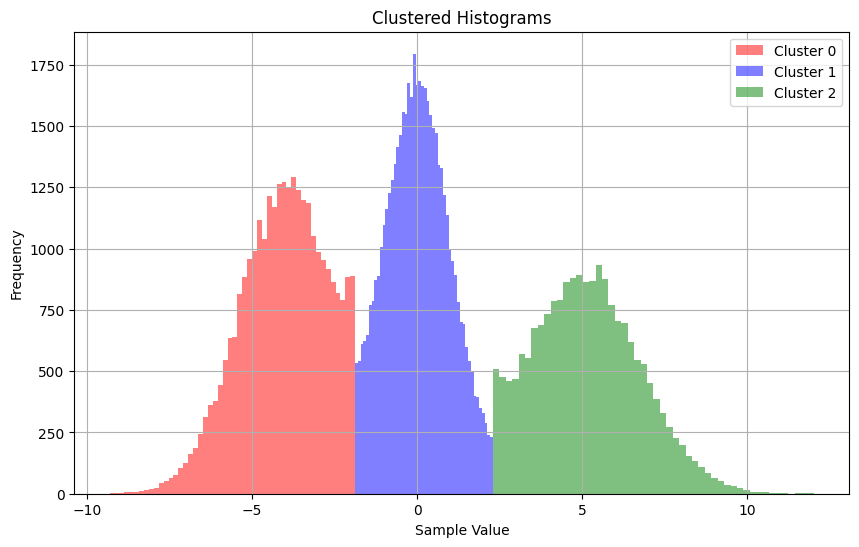

In [14]:
### Solution ###
# Hard clustering: Assign each point to the cluster with the highest lambda value
z = np.argmax(lamb, axis=1)

# Colors for each cluster: 0 -> red, 1 -> blue, 2 -> green
colors = ['red', 'blue', 'green']

# Plot histograms for each cluster
plt.figure(figsize=(10, 6))

for k in range(3):
    plt.hist(X[z == k], bins=50, alpha=0.5, color=colors[k], label=f'Cluster {k}')

plt.title('Clustered Histograms')
plt.xlabel('Sample Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


## Extras

Here are some of the things that can be tried out:

- Make the stopping criterion more stringent and see the effect it has on the number of iterations
- Change the size of the dataset and study the effect it has on convergence.
- Change the initialization and study the effect it has on convergence
- Change the number of mixtures and see what happens